In [3]:
import numpy as np
import h5py
import cv2
import os, sys
import argparse
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img
from scipy.ndimage import median_filter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:

debug = True
data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned"
for set_path in sorted(os.listdir(data_path)):
    if debug is True:
        print(set_path)
    set_path = os.path.join(data_path,set_path)
    img_list = sorted(os.listdir(set_path))
    img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
    if debug is True:
        print(img_list)
    for img_path in img_list:
        img_path = os.path.join(set_path,img_path)
        if "F32" not in img_path : # find f32 image
            print(img_path)
            continue
        
        if "F32_1.png" in img_path:
            continue
        if debug is True:
            print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        if debug is True:
            print(img.shape)
        sys.exit(-1)

SET1
['F16_1.png', 'F16_10.png', 'F16_11.png', 'F16_12.png', 'F16_13.png', 'F16_14.png', 'F16_15.png', 'F16_16.png', 'F16_2.png', 'F16_3.png', 'F16_4.png', 'F16_5.png', 'F16_6.png', 'F16_7.png', 'F16_8.png', 'F16_9.png', 'F32_1.png', 'F32_10.png', 'F32_11.png', 'F32_12.png', 'F32_13.png', 'F32_14.png', 'F32_15.png', 'F32_16.png', 'F32_2.png', 'F32_3.png', 'F32_4.png', 'F32_5.png', 'F32_6.png', 'F32_7.png', 'F32_8.png', 'F32_9.png', 'F64_1.png', 'F64_10.png', 'F64_11.png', 'F64_12.png', 'F64_13.png', 'F64_14.png', 'F64_15.png', 'F64_16.png', 'F64_2.png', 'F64_3.png', 'F64_4.png', 'F64_5.png', 'F64_6.png', 'F64_7.png', 'F64_8.png', 'F64_9.png', 'F8_1.png', 'F8_10.png', 'F8_11.png', 'F8_12.png', 'F8_13.png', 'F8_14.png', 'F8_15.png', 'F8_16.png', 'F8_2.png', 'F8_3.png', 'F8_4.png', 'F8_5.png', 'F8_6.png', 'F8_7.png', 'F8_8.png', 'F8_9.png']
/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F16_1.png
/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_ali

SystemExit: -1

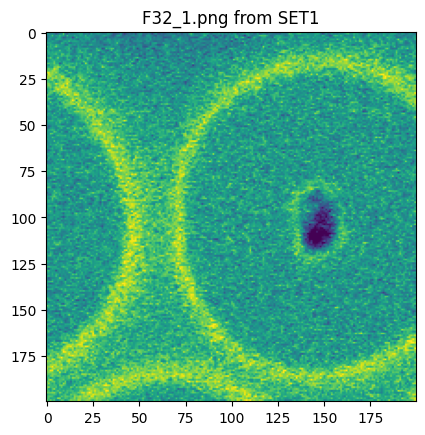

In [88]:
plt.title(f"F32_1.png from SET1")
plt.imshow(img[:200,:200])

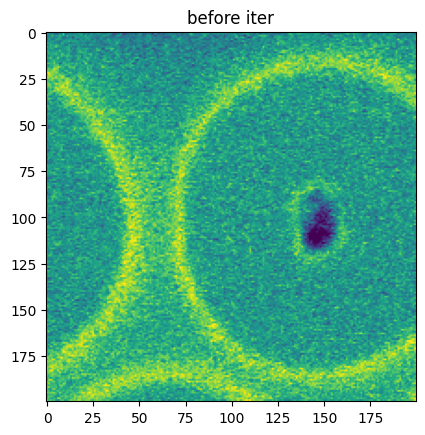

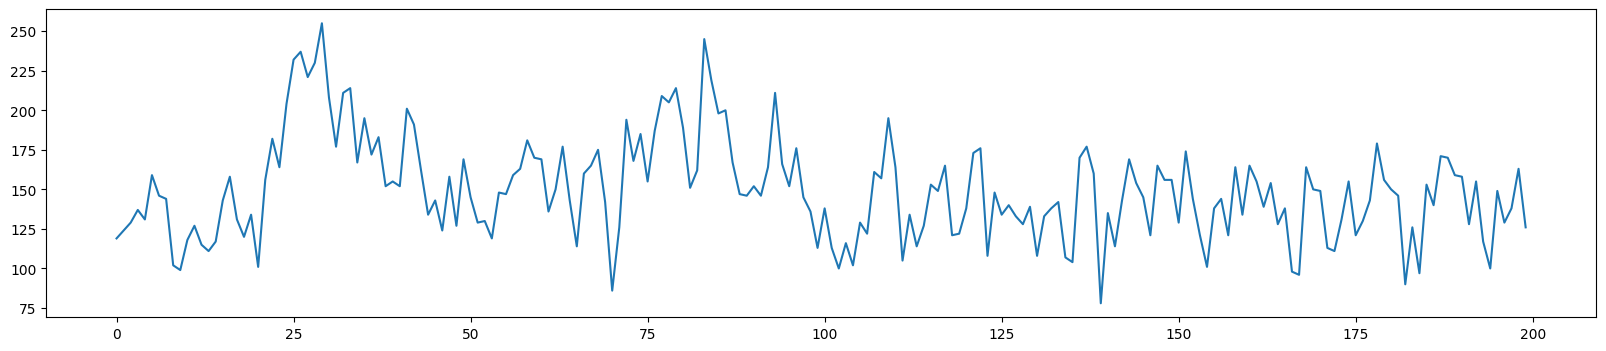

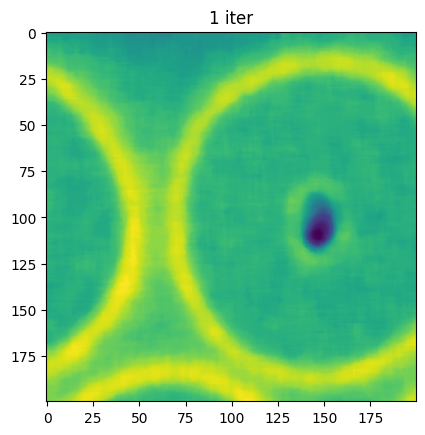

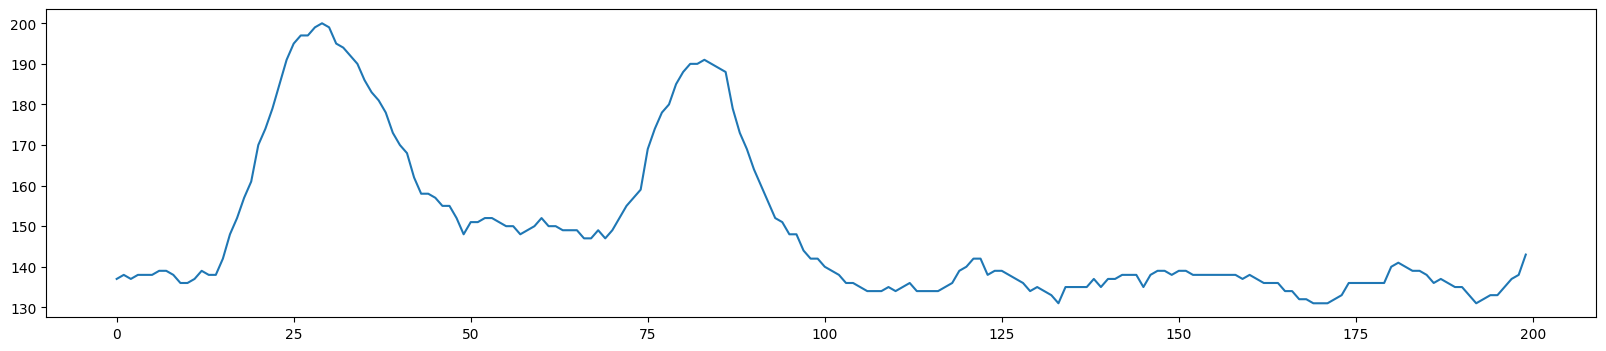

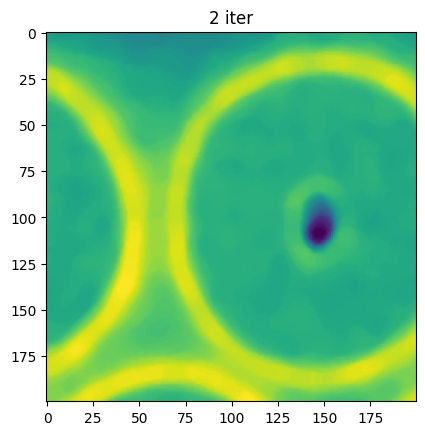

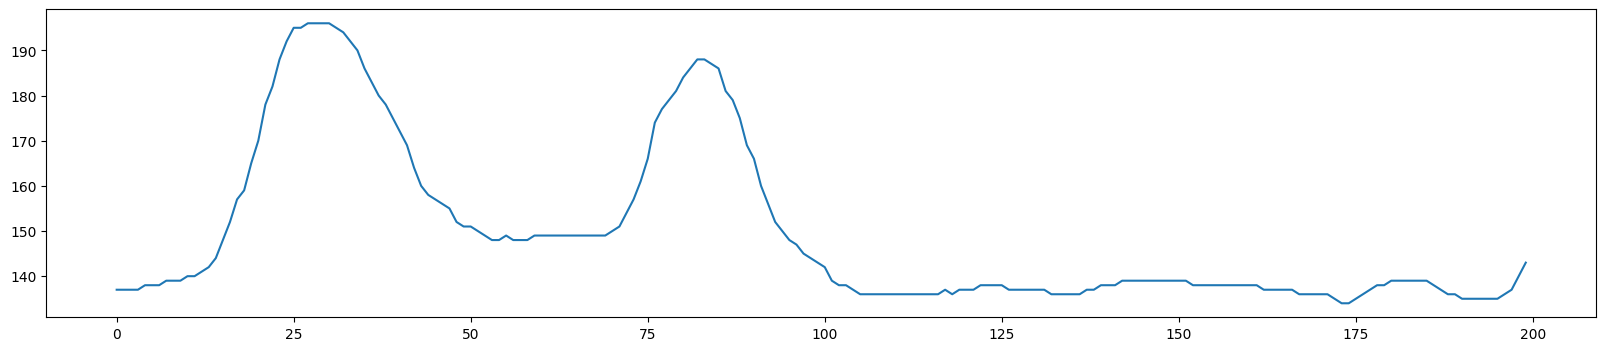

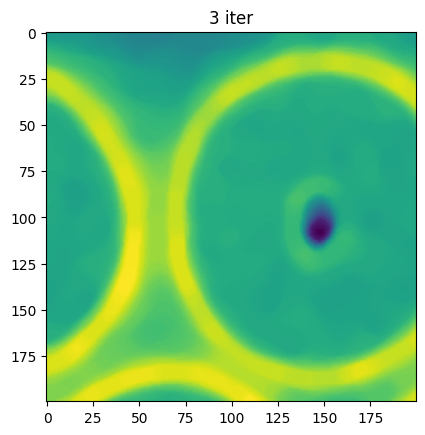

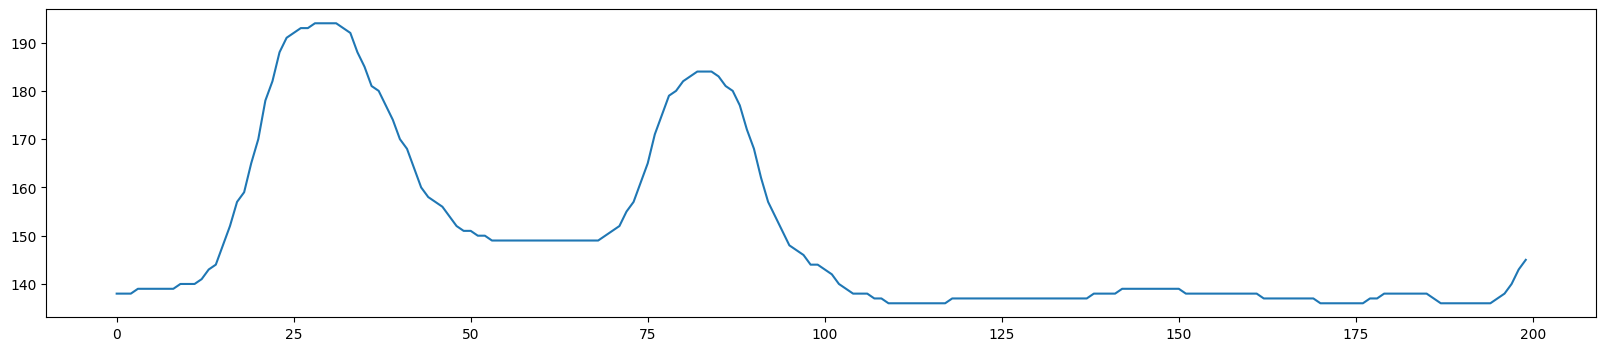

In [89]:
from copy import deepcopy
out = deepcopy(img)
plt.title(f'before iter')
plt.imshow(out[:200,:200])
plt.pause(0.01)
plt.figure(figsize=(20,4))
plt.plot(out[50][:200])
plt.pause(0.01)
for i in range(3):
    out = median_filter(out,(11,11))
    plt.title(f'{i+1} iter')
    plt.imshow(out[:200,:200])
    plt.pause(0.01)
    plt.figure(figsize=(20,4))
    plt.plot(out[50][:200])
    plt.pause(0.01)

In [68]:
out.min(), out.max()

(0, 218)

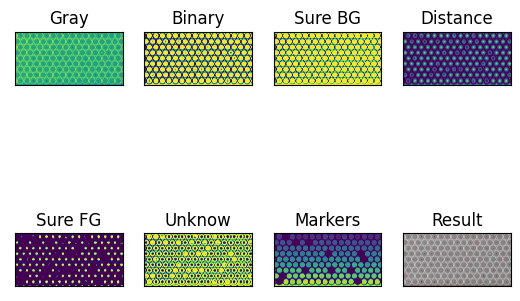

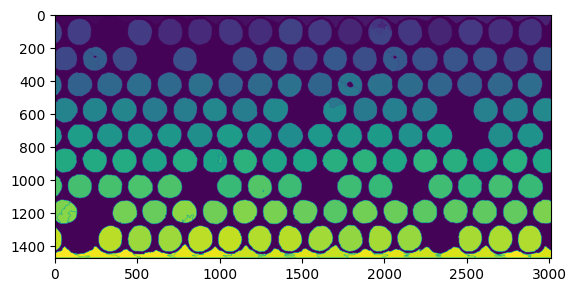

In [95]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')

gray = out
b = np.zeros((out.shape[0],out.shape[1],3)).astype('uint8')
b[:,:,0] = out
b[:,:,1] = out
b[:,:,2] = out

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=4)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(b,markers)
b[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, b]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

[  -1    0    1 ... 1145 1146 1147]
cricle_value is 255
2623 273


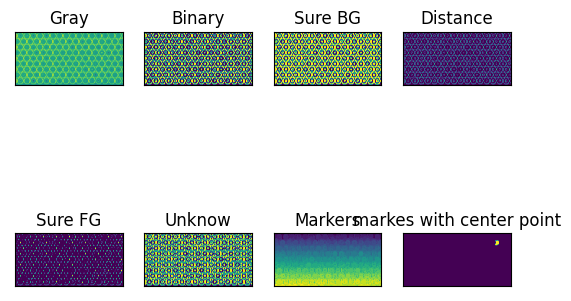

In [96]:
#print(img_name)
r = watershed(out,0,True) #  

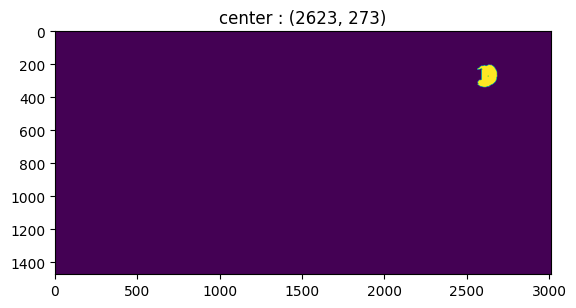

In [92]:
plt.title(f"center : {r[0]}")
plt.imshow(r[-1])#[:200,:200])

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
cricle_value is 8
140 101


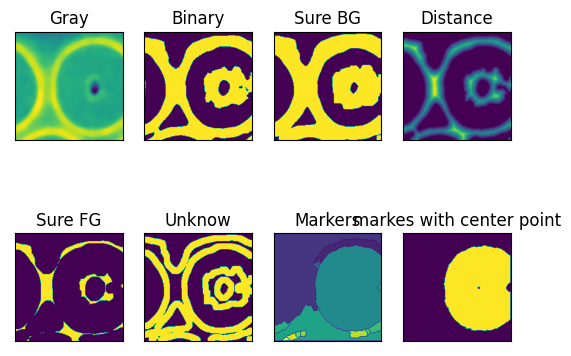

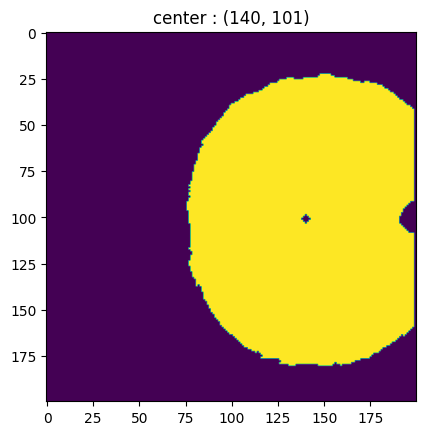

In [97]:
subset_r = watershed(out[:200,:200],0,True)
plt.title(f"center : {subset_r[0]}")
plt.imshow(subset_r[-1])#[:200,:200])